# **CRY ANALYSIS**
* ## Machine Learning Model to classify the reasons for infant cries **"Hungry or Not Hungry"** with a high degree of accuracy using Convolutional Neural Network 'CNN'.

## Import Modules

In [15]:
import onnx
import keras2onnx
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

# SageMaker Service 
## It is a service in Amazon Web Services to provide a cloud platform for machine-learning.

In [ ]:
import sagemaker, boto3
from sagemaker import get_execution_role

sess = sagemaker.Session()
aws_role = get_execution_role()
aws_region = boto3.Session().region_name

bucket= 'radi'
prefix = 'Hungry'
data_location = 's3://{}/{}'.format(bucket, prefix)

# Define Constants

In [27]:
BATCH_SIZE=20
IMAGE_WIDTH=400
IMAGE_HEIGHT=400
IMAGE_CHANNELS=3
FAST_RUN = False
EPOCHS=3 if FAST_RUN else 50
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Build Model

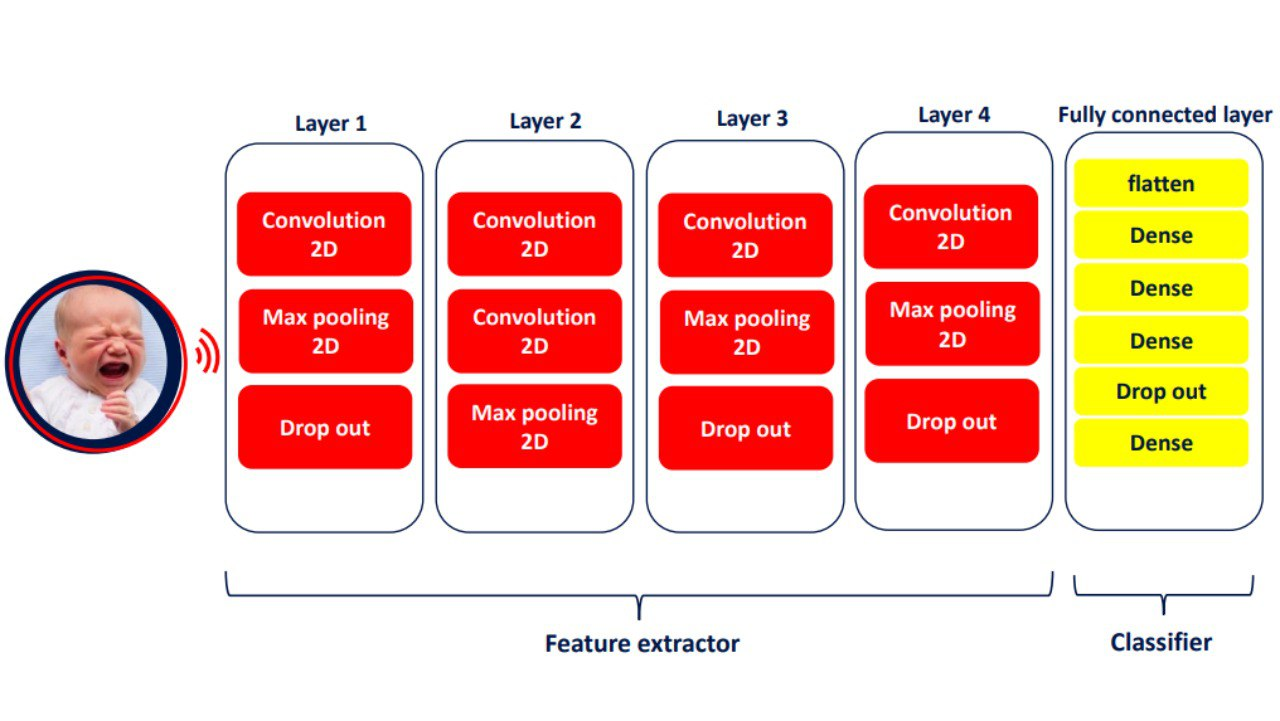

In [1]:
from IPython import display
display.Image(f"{data_location}/BuildModel.jpg")

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 500x500 = 250000, it will convert to (250000,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer.
* **Output Layer**: It is the predicted values layer. 

In [18]:
def create_cnn():
    model = Sequential()
    
    #### input layer  #### 
    model.add(Conv2D(64, (3,3), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    model.add(Activation('relu'))

    ### hidden layers ###
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(rate=0.20))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.20))

    model.add(Conv2D(32, (2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.20))

    ### output layers ###
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(rate=0.20))
    model.add(Dense(2)) # 2 classifications.
    model.add(Activation('softmax'))
    #optimizer='adam'or 'rmsprop'
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model 

# Callbacks

**Early Stop**

To prevent over fitting we will stop the learning after 5 epochs and val_loss value not decreased

In [19]:
earlystop = EarlyStopping(monitor="accuracy",
                          min_delta=0.01,
                          patience=5,
                          verbose=1 )

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            min_lr=0.00001,
                                            patience=2, 
                                            verbose=1)

**Model Check point**

We will save the best weights when the validation accuracy not increase

In [21]:
modelCheckpoint=  ModelCheckpoint(filepath=f"{data_location}/models/best_validation_hungry_model.h5",
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)

# Training Generator

In [22]:
train_generator = ImageDataGenerator( rescale = 1.0/255.).flow_from_directory(
    f'{data_location}/data_set/train_data',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='categorical')


Found 595 images belonging to 2 classes.


### Validation Generator

In [23]:
validation_generator = ImageDataGenerator( rescale = 1.0/255.).flow_from_directory(
     f'{data_location}/data_set/validation_data',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 175 images belonging to 2 classes.


# Fit Model

In [28]:
cnn = create_cnn()

cnn.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=595 //BATCH_SIZE,
    validation_steps=175 //BATCH_SIZE,
    validation_data=validation_generator,
    callbacks = [modelCheckpoint,earlystop, learning_rate_reduction]
)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.7973
Epoch 1: val_accuracy improved from -inf to 0.78750, saving model to models\best_validation_model.h5
19/19 [==============================] - 91s 5s/step - loss: 0.5076 - accuracy: 0.7973 - val_loss: 0.5234 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.4000 - accuracy: 0.8849
Epoch 2: val_accuracy improved from 0.78750 to 0.86250, saving model to models\best_validation_model.h5
19/19 [==============================] - 129s 7s/step - loss: 0.4000 - accuracy: 0.8849 - val_loss: 0.5153 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.8385
Epoch 3: val_accuracy did not improve from 0.86250
19/19 [==============================] - 119s 6s/step - loss: 0.5103 - accuracy: 0.8385 - val_loss: 0.5704 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/50
19/19 [================

# Save Model

In [52]:
cnn.save( f'{data_location}/models/hungry_prediction_model.h5', overwrite=True)
cnn.save_weights( f'{data_location}/models/weights_hungry_prediction_model.h5')
history = cnn.history.history

# Virtualize Training

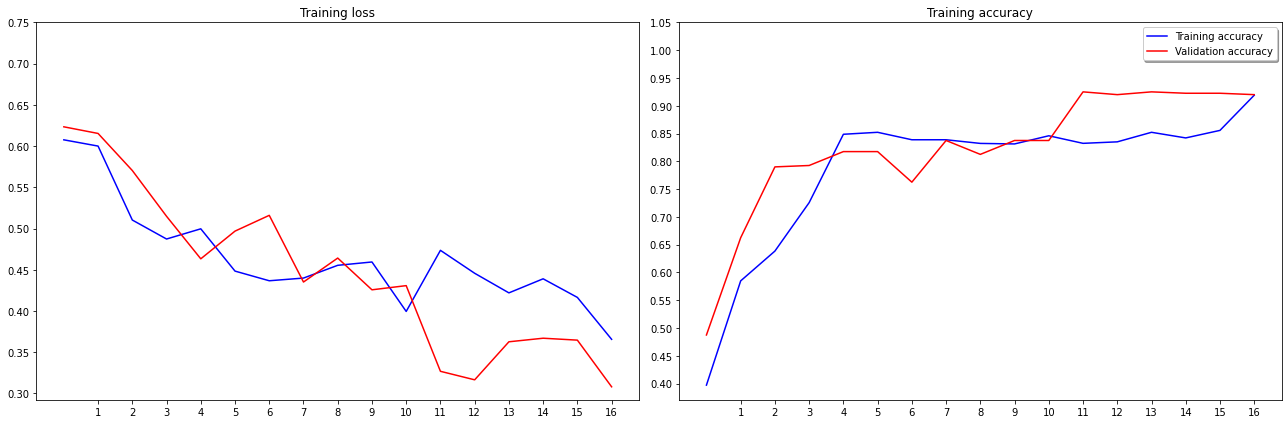

<Figure size 432x288 with 0 Axes>

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.plot(history['loss'], color='b', label="Training loss")
ax1.plot(history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 17, 1))
ax1.set_yticks(np.arange(0.3, 0.8, 0.05))
ax1.title.set_text('Training loss')

ax2.plot(history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 17, 1))
ax2.set_yticks(np.arange(0.4, 1.1, 0.05))
ax2.title.set_text('Training accuracy')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()
plt.savefig('models/loss_accuracy.pdf', bbox_inches='tight')

# Testing Generator

In [102]:
test_generator = ImageDataGenerator( rescale = 1.0/255.).flow_from_directory(
     f'{data_location}/data_set/test_data',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='categorical')

Found 84 images belonging to 2 classes.


# Evaluate

In [101]:
model = load_model( f'{data_location}/models/hungry_prediction_model.h5')
loss, acc = model.evaluate(test_generator, verbose=2)

3/3 - 7s - loss: 0.3316 - accuracy: 0.9103 - 7s/epoch - 2s/step


# Predict

In [95]:
img_path= f'{data_location}/data_set/predict/hungry.png'
model.predict(np.expand_dims(image.img_to_array(image.load_img(img_path, target_size=IMAGE_SIZE)), axis=0))

array([[1., 0.]], dtype=float32)

# Convert to ONNX File

In [ ]:
backend_model = keras2onnx.convert_keras(model, model.name)
onnx.save_model(backend_model,  f'{data_location}/models/hungry_prediction_model.onnx')